# Welcome to ESS-DIVE's API Demo Jupyter Notebook
**This Jupyter Notebook will help anyone who is new to ESS-DIVE's Dataset API learn how to:**
- Perform a dataset search with the API
- Use the results to create a project dataset report
- Download data files from ESS-DIVE for visualization

_This was created as a complementary resource to ESS-DIVE's September 2022 Webinar_

_Written By: Madison Burrus & Valerie Hendrix_
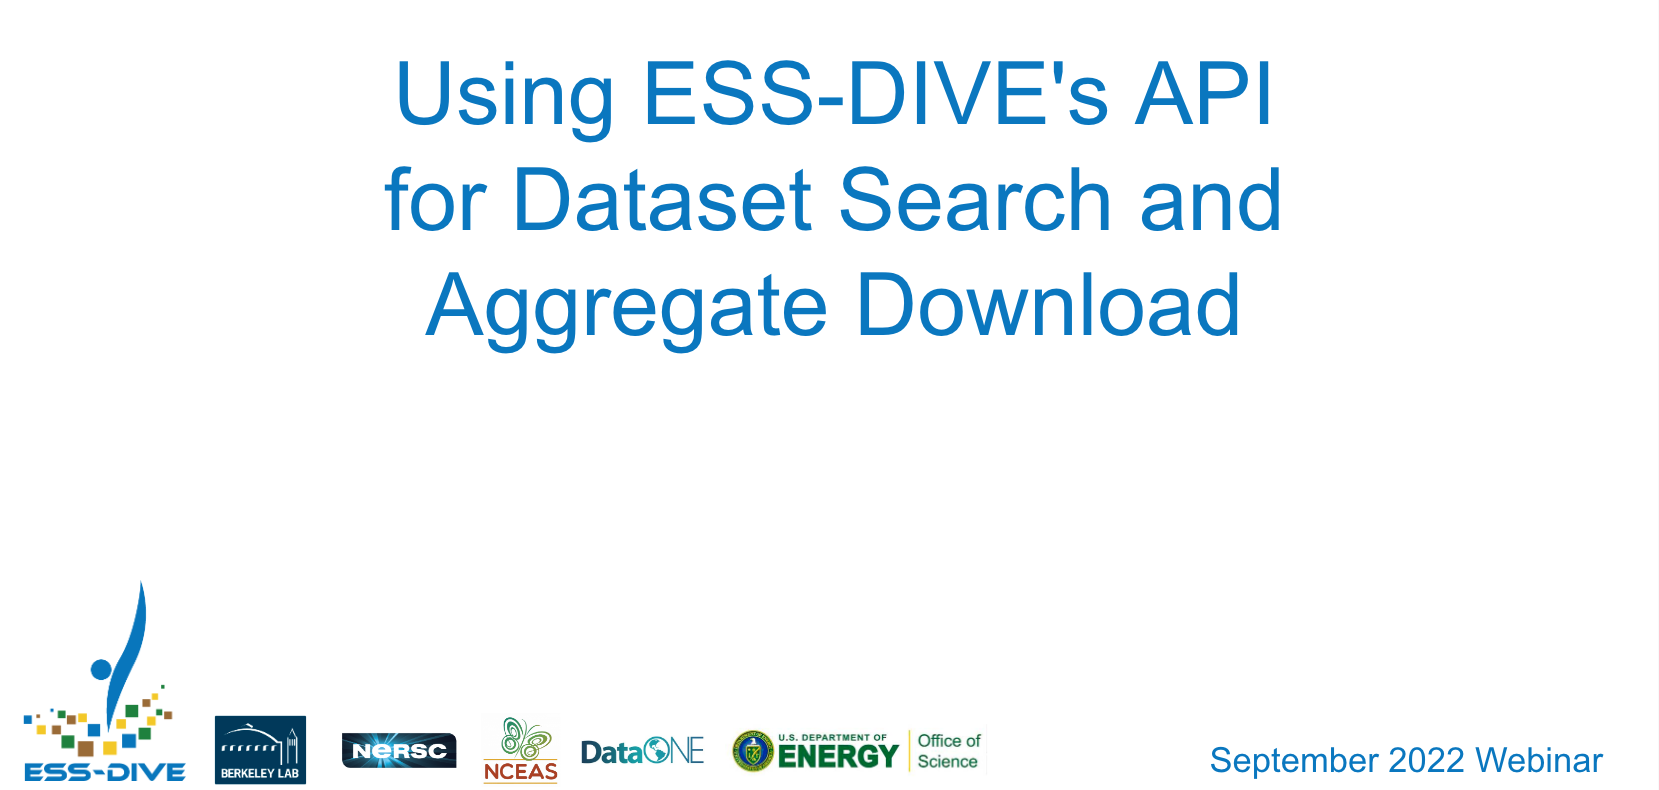

# Part One: Search for Datasets with the API
## 1. Setup
The code cell below imports necessary libraries and creates an empty widget used for entering your authentication token into this notebook.

1. Run cell, leave the token widget empty and continue.

In [ ]:
# Import libraries
import pandas
import requests
import os
from ipywidgets import widgets, interact
from IPython.display import display, display_html
import urllib.request
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

# Setup the inputs
token_text = widgets.Text("", description="Token:")
display(token_text)


2. Go to ESS-DIVE (https://data.ess-dive.lbl.gov/data), login with your ORCID, and copy your authentication token from your account settings page.
3. Enter your authentication token into the widget above
4. Run the following code cell

   _Always re-run this code cell when you update your token. Tokens expire every 24 hours._

In [ ]:
token=token_text.value
essdive_api_url='https://api.ess-dive.lbl.gov'

## 2. Create Search Query for Public datasets
You can search for datasets using any of the following parameters:
- Dataset Creator
- Date Published
- Project Name
- Any text 


**To learn how to format a search parameter for the Dataset API, visit the techincal documentation at** https://api.ess-dive.lbl.gov/#/Data%20Package/listPackages. 

A screenshot of the formatting instructions is provided below 👇

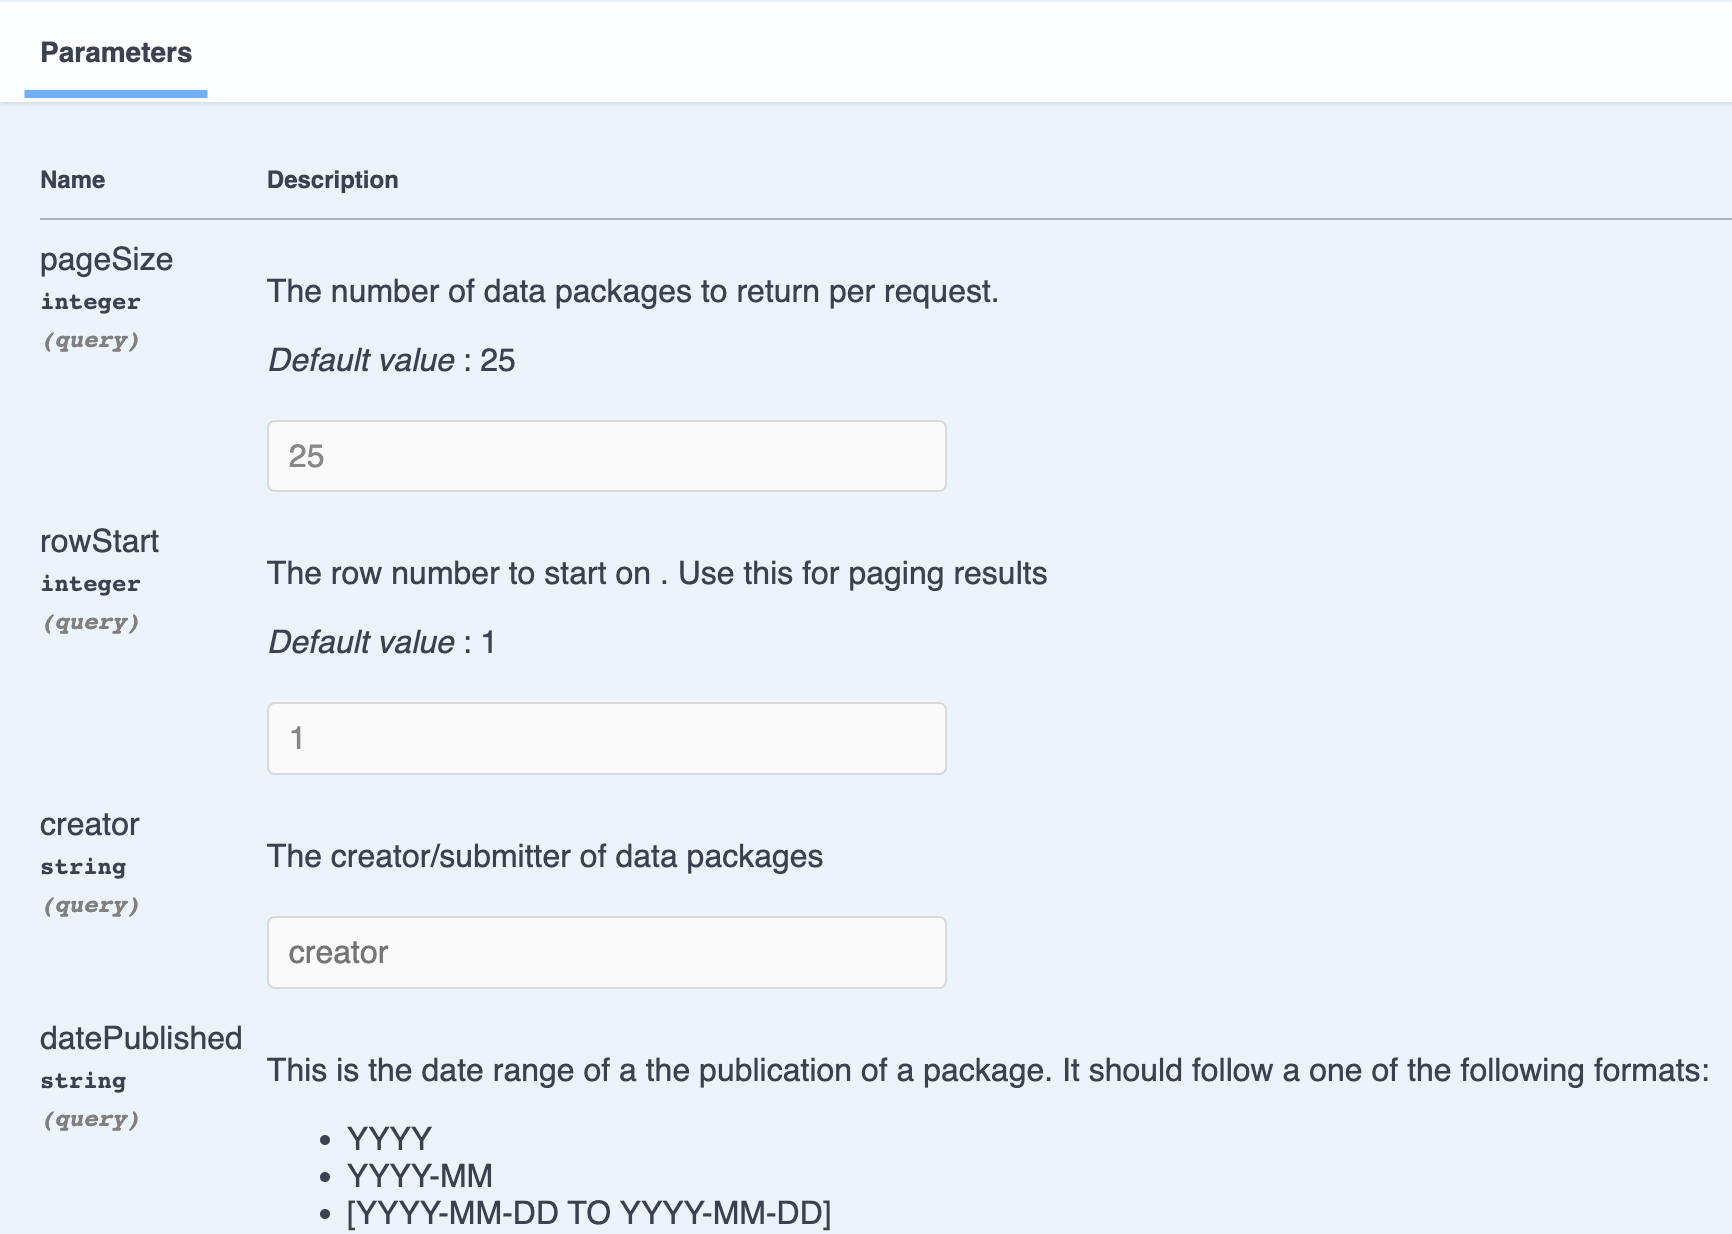
_Figure 1: A screenshot of the search parameter formatting instructions from the Dataset API's technical documentation (https://api.ess-dive.lbl.gov)._
<br>


<br>

The example below performs a search for all **public datasets published under a specific project**.

5. Optional: Go to [ESS-DIVE's project list](https://docs.google.com/spreadsheets/d/179SOyv42wXbP4owWZtUg3RqhW9dPOyENYcVYuUCcqwg/edit?usp=sharing) to find the controlled name for your project
<br>    To search for an exact match, enter project name in the format of `"\"<project name>\""`
6. Define your search parameters here

In [ ]:
# Define parameter variables
project="\"Next-Generation Ecosystem Experiments (NGEE) Arctic\""
creator="<creator/submitter name>"
text= "<enter search term>"
datePublished = "<[YYYY TO YYYY-MM-DD]>"

7. Enter any additional parameters you'd like to the `get_packages_response` string in the format of: `datePublished=\"{datePublished}\"`

_Note: When using the `text` parameter, search exact text matches by using the format `"\"<text>\""`_

In [ ]:
# Contruct URL query to send to the Dataset API
get_packages_response = f"{essdive_api_url}/packages?providerName={project}&isPublic=true"

## 3. Run code & Debug
8. Run the following code cell
9. Continue when you receive a "Success!" response
10. Stop and debug the issue if you receive an error.

In [ ]:
# Send request to Dataset API
response = requests.get(get_packages_response, 
                          headers={"Authorization": f"Bearer {token}"})

# Review the response and debug if needed
if response.status_code == 200:
    # Success
    response_json = response.json()
    print("Success! Continue to look at the search results")  

else:
    # There was an error
    print("There was an error. Stop here and debug the issue. Email ess-dive-support@lbl.gov if you need assistance. \n")
    print(response.text)

## 4. Look at Search results
11. Run the following cell and take a look at the JSON response. We will parse this output and do more with it in the next section of this notebook.

In [ ]:
print("This is what a dataset search JSON result looks like with the API. \n")
display(response_json)

----

<br><br><br>

# Part Two: Dataset Report for Project
Using the results from Part One, we'll now create a dataset report that includes a list of all datasets published by one project.


## 1. Prepare List of Datasets
First, grab the list of datasets from the results and enter it into a variable

In [ ]:
# Grab list of results to pass into variable
results=response_json['result']

Then review the total number of results.


We're looking at how many results there are because the API does not print more than 100 datasets in the results. If we have more than 100 datasets, we'll need to run another line of code (not shown here, see message if this occurs).


In [ ]:
print("Total datasets that match search results: ",response_json['total'])

if response_json['total'] > 100:
    print("This call cannot print more than 100 results. Change the `pageSize` to 100, \
    re-run the call then change rowStart to 100 and re-run the call as many times as needed until you have paged\
    through all, ",response_json['total']," results.")
    
else:
    "do nothing"

## 2. Define pandas dataframe display
In the following code cell, we're defining a function that grabs the metadata fields we want to include in our report from the JSON search result and puts it into a data frame, as well as setting some display settings for our final data frame.  

This example report will include the following fields:
- Dataset DOI
- Dataset Title
- Publication Date

In [ ]:
# Function to define what we want in the dataframe
def grab_metadata(r_json):
    df = pandas.DataFrame()
    
    for dataset in r_json:
        access = dataset['isPublic']
        doi = dataset['dataset']['@id']
        title = dataset['dataset']['name']
        publicationDate = dataset['dataset']['datePublished']
        report={'Public':access, 'Title':title, 'Publication Date':publicationDate, 'DOI':doi}
        df = df.append(report, ignore_index=True)
        
    return df

# Change dataframe display options to better visualize the results
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_colwidth', None)
pandas.set_option('display.colheader_justify', 'left')

## 3. Create, Summarize and Display Dataframe
Using the function defined above, we'll quickly create and display the dataframe using the cells below.

In [ ]:
# Create dataframe for the report
project_report=(grab_metadata(results))

In [ ]:
# Display dataframe
display(project_report.style.set_properties(**{'text-align': 'left'}))

#### We can also summarize some information in this dataframe
In this case, we chose to look at the range of publication dates for our list of datasets

In [ ]:
pub_dates=project_report['Publication Date'].unique()
sorted(pub_dates)

## 4. Export dataframe as a csv

We'll create a new directory to download outputs from this jupyter notebook. In the following cell we:
- Name a new directory in our working directory
- Name the new dataset report file
- Create a new directory
- Save the dataset report to the new directory as a CSV

In [ ]:
# Define file name, directory name, and file paths
file_name = 'project_report_example.csv'
new_dir = 'ESS-DIVE_Downloads'
parent_dir = os.getcwd()
path = os.path.join(parent_dir, new_dir)
file_path=os.path.join(path, file_name)

In [ ]:
# attempt to make the new folder if it doesn't already exist
try: 
    os.mkdir(path)
    print("Directory '% s' created" % new_dir)
except OSError as error: 
    print(error)  

In [ ]:
try:
    project_report.to_csv(file_path, sep=',', index=False)
    print("Your dataset report has been saved!")
except:
    print("Save failed.")

----

<br><br><br>

# Part Three: Download & Visualize Data Files
Using the results from part one, we will look up an idividual dataset using the dataset ID to download data files off of ESS-DIVE. In this example, we grab only one data file and we do not loop through multiple files or datasets.

## 1. Grab a dataset ID from search result
For this example, we'll use the Dataset ID from the first dataset in the search result

In [ ]:
dataset_id = response.json()['result'][0]['id']

## 2. Enter dataset ID into new request URL
Much like in Part one, we'll add the dataset ID parameter into the URL following a specific format. **To learn how to format an individual dataset search with the Dataset API, visit the techincal documentation at** https://api-sandbox.ess-dive.lbl.gov/#/Data%20Package/getPackage. 

In [ ]:
get_package_url=f"{essdive_api_url}/packages/{dataset_id}"

## 3. Send request and debug

In [ ]:
# Get a CSV file from the dataset
dataset_response = requests.get(get_package_url,
                          headers={"Authorization": f"Bearer {token}"})

if dataset_response.status_code == 200:
    # Success
    print("Success! Continue to look at the complete dataset metadata and files.")
    dataset_json = dataset_response.json()['dataset']

else:
    # There was an error
    print(dataset_response.text)


## 4a. Review individual dataset metadata JSON

In [ ]:
print("This is what an individual dataset search JSON result looks like with the API. \n")
display(dataset_json)


## 4a. Review individual dataset data 

In [ ]:
# Function to define what we want in the dataframe
def dataset_files(dataset_json):
    df = pandas.DataFrame()
    
    for count, item in enumerate(dataset_json['distribution']):
        df_new_row = pandas.DataFrame(item, index=[count])
        df = pandas.concat([df, df_new_row])
    return df


display_html("<h2>FILES</h2><p><em>contentSize is in kilobytes</em></p>", raw=True)
display(dataset_files(dataset_json))


## 5. Grab the data file URL
Save the data file object to a variable. This object contains the data file's:
- URL
- Name
- Enoding format

In this example, we search for the first csv file listed in the dataset. 
        
        !! If there are no csv files, the `csv_file` assignment will result in an error. Change the encoding format or change condition if you want to work with other formats. !!

In [ ]:
# Get a CSV file from the dataset
csv_file = [d for d in dataset_json['distribution'] if d['encodingFormat'] == 'text/csv'][0]
print(f"File Name: {csv_file['name']}")

## 6. Import data file into Jupyter Notebook
We'll use the data file URL to download the file. In this example, we are only downloading the first csv file listed in the dataset.

In [ ]:
# Import CSV file as dataframe
req = Request(csv_file['contentUrl'])
req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
content = urlopen(req)

## 7. Download data file to local folder
We'll use the same directory we created in Part Two

In [ ]:
data_file_path=os.path.join(path, csv_file['name'])

try:
    urllib.request.urlretrieve(csv_file['contentUrl'], data_file_path)
    print(f"File Saved: {csv_file['name']}")
except:
    print("Save failed.")


## 8. Convert csv to dataframe
At this point, we'll also re-format the data as needed for summarizing or visualization

In [ ]:
df = pandas.read_csv(content)

In [ ]:
# Convert Date string to Date type
df['Date'] = pandas.to_datetime(df['Date'], format='%Y%m%d')
df

## 9. Summarize the data

In [ ]:
df.max(numeric_only=True)

In [ ]:
df.groupby('Date').agg({'C:N': ['min', 'max', 'mean'], 
                        'C (%)': ['min', 'max', 'mean'], 
                        'N (%)': ['min', 'max', 'mean'] })
  

In [ ]:
df.groupby('Site').agg({'C:N': ['min', 'max', 'mean'], 
                        'C (%)': ['min', 'max', 'mean'], 
                        'N (%)': ['min', 'max', 'mean'] })

In [ ]:
df.groupby('Species').agg({'C:N': ['min', 'max', 'mean'], 
                        'C (%)': ['min', 'max', 'mean'], 
                        'N (%)': ['min', 'max', 'mean'] })